In [155]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, isnull, pow, sqrt, regexp_extract, regexp_replace, format_number, avg, round, lit, desc,countDistinct,collect_list, first
from pyspark.ml.feature import Imputer
from pyspark.sql.types import StructType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [156]:
spark = SparkSession.builder.appName("practica").getOrCreate()
spark.conf.set("spark.hadoop.mapreduce.fileoutputcommitter.marksuccessfuljobs", "false")

In [157]:
#vamos a automatizar la creacion de las graficas segun su categoria.

#Primero importamos los datos.

df = spark.read.csv("../raw/googleplaystore.csv", header=True, inferSchema=True)

In [158]:
#Queremos representar una grafica por cada category, primero hagamos una sencilla para una category solo.

#importamos una para probar.

df_art = spark.read.csv("../data/processed/datos_filtrados/ART_AND_DESIGN.csv", header=True, inferSchema=True)

In [159]:
df_art.show()

+--------------+--------------+-----+--------------+----------+-----------+---------------------+
|      Category|content rating|count|  avg_installs|avg_rating|avg_reviews|version_mas_utilizada|
+--------------+--------------+-----+--------------+----------+-----------+---------------------+
|ART_AND_DESIGN|          Teen|    3|2.0003333333E7|     4.467|    86942.0|   Varies with device|
|ART_AND_DESIGN|  Everyone 10+|    1|      500000.0|       4.7|     7699.0|              2.2.6.2|
|ART_AND_DESIGN|      Everyone|   61|   1046362.295|     4.347|  23703.525|                    1|
+--------------+--------------+-----+--------------+----------+-----------+---------------------+



In [160]:
#desde spark no podemos hacer nada, lo pasamos a pandas.
df_art = df_art.toPandas()

In [161]:
df_art

,Category,content rating,count,avg_installs,avg_rating,avg_reviews,version_mas_utilizada
0,ART_AND_DESIGN,Teen,3,2.000333e+07,4.467,86942.000,Varies with device
1,ART_AND_DESIGN,Everyone 10+,1,5.000000e+05,4.700,7699.000,2.2.6.2
2,ART_AND_DESIGN,Everyone,61,1.046362e+06,4.347,23703.525,1


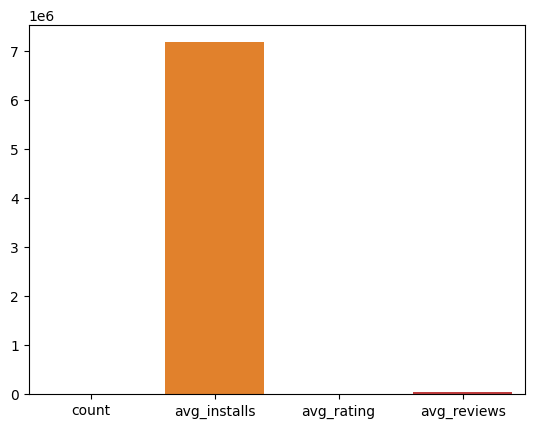

In [162]:
sns.barplot(df_art, errorbar=None);

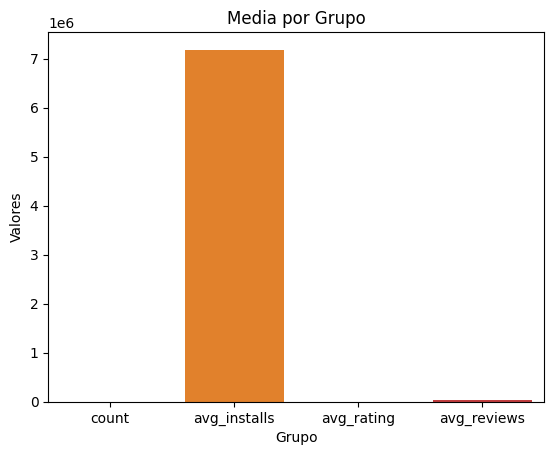

In [163]:
#Parece que va bien, pero avg_install tiene un valor demasiado alto comparada con el resto.

#Haremos lo siguente, vamos a decorarla un poco y dejarla como plantilla.

sns.barplot(df_art, errorbar=None);
plt.title('Media por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Valores')
plt.show()

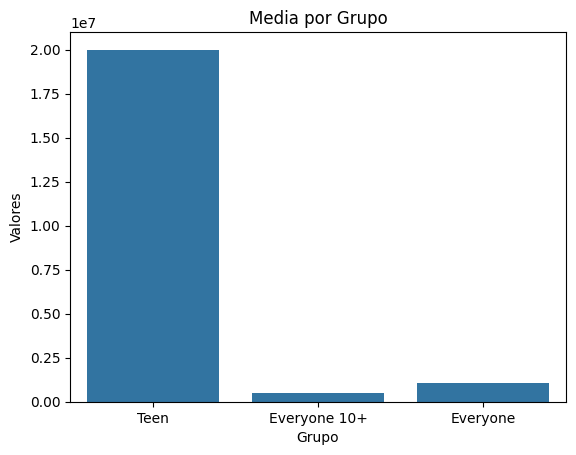

In [164]:
#Parece que funciona, pero tenemos 3 valores de avg installs separadas por el content_rating, vamos a verlo.

sns.barplot(data=df_art, x="content rating", y="avg_installs", errorbar=None);
plt.title('Media por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Valores')
plt.show()

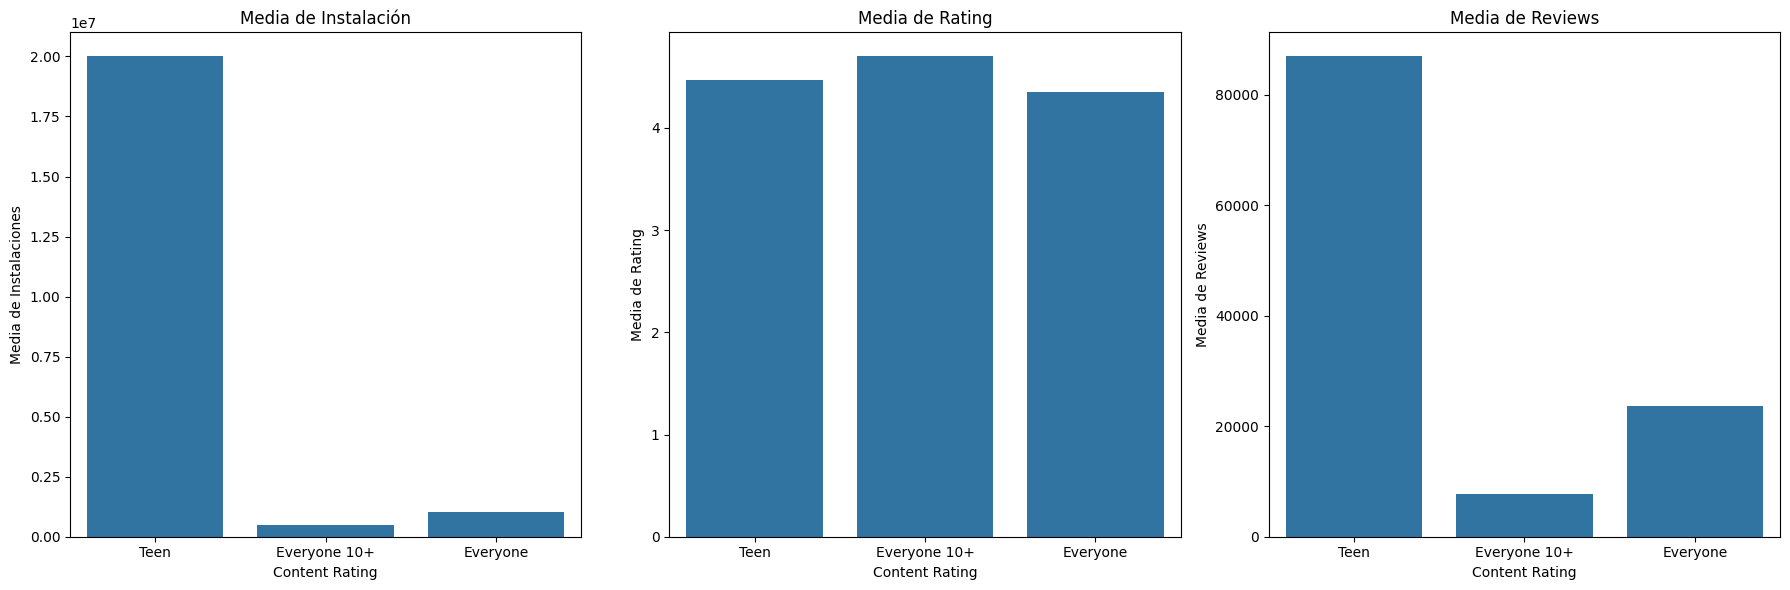

In [165]:
#tenemos 3 avg, vamos a poner las 3 a la vez una al lado de otra.

fig, axes = plt.subplots(1, 3, figsize=(18, 6))


sns.barplot(x="content rating", y="avg_installs", data=df_art, ax=axes[0])
axes[0].set_title('Media de Instalación')
axes[0].set_xlabel('Content Rating')
axes[0].set_ylabel('Media de Instalaciones')


sns.barplot(x="content rating", y="avg_rating", data=df_art, ax=axes[1])
axes[1].set_title('Media de Rating')
axes[1].set_xlabel('Content Rating')
axes[1].set_ylabel('Media de Rating')


sns.barplot(x="content rating", y="avg_reviews", data=df_art, ax=axes[2])
axes[2].set_title('Media de Reviews')
axes[2].set_xlabel('Content Rating')
axes[2].set_ylabel('Media de Reviews')


plt.tight_layout()


plt.show()

In [166]:
#Vale ya tenemos un modelo basico, vamos a intentar ir a mas.

#vamos a cargar TODAS las categorias del df y las vamos a imprimir.

#primer paso, meter en una lista todas las categorias que vamos a usar.

#reuso el codigo que use antes para quitar las categorias no usadas.
df = df.filter(df["category"] != "1.9")
df = df.filter(~col("category").contains("traffic"))
df = df.filter(df["category"] != "Face")

#cojemos las columnas unicas ahora.

columna = df.select("Category").distinct()
lista = []

for i in columna.select("category").collect():
    lista.append(i[0])

In [167]:
lista

['EVENTS',
 'COMICS',
 'SPORTS',
 'WEATHER',
 'VIDEO_PLAYERS',
 'AUTO_AND_VEHICLES',
 'PARENTING',
 'ENTERTAINMENT',
 'PERSONALIZATION',
 'HEALTH_AND_FITNESS',
 'TRAVEL_AND_LOCAL',
 'BOOKS_AND_REFERENCE',
 'FOOD_AND_DRINK',
 'PHOTOGRAPHY',
 'BUSINESS',
 'FAMILY',
 'SHOPPING',
 'HOUSE_AND_HOME',
 'GAME',
 'EDUCATION',
 'PRODUCTIVITY',
 'TOOLS',
 'LIFESTYLE',
 'NEWS_AND_MAGAZINES',
 'MEDICAL',
 'COMMUNICATION',
 'MAPS_AND_NAVIGATION',
 'DATING',
 'LIBRARIES_AND_DEMO',
 'BEAUTY',
 'SOCIAL',
 'FINANCE',
 'ART_AND_DESIGN']

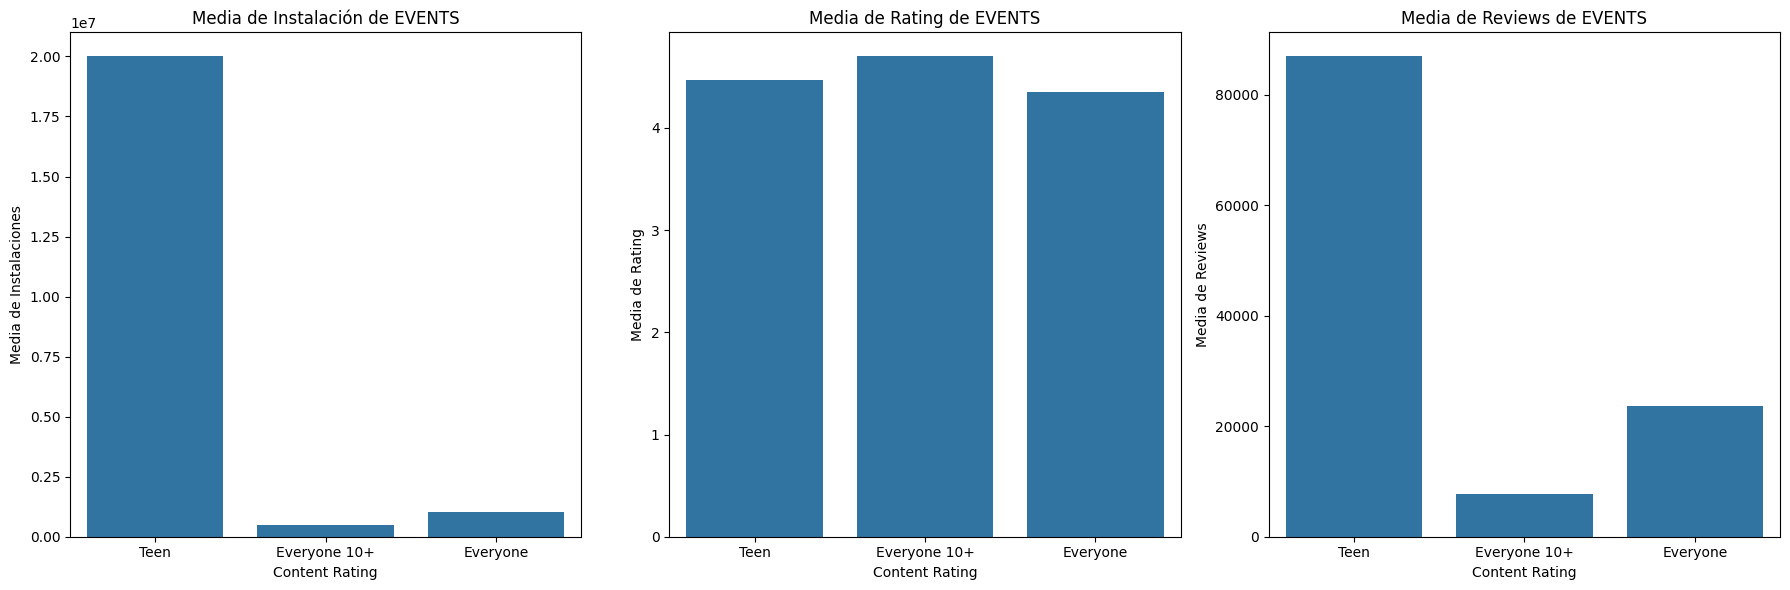

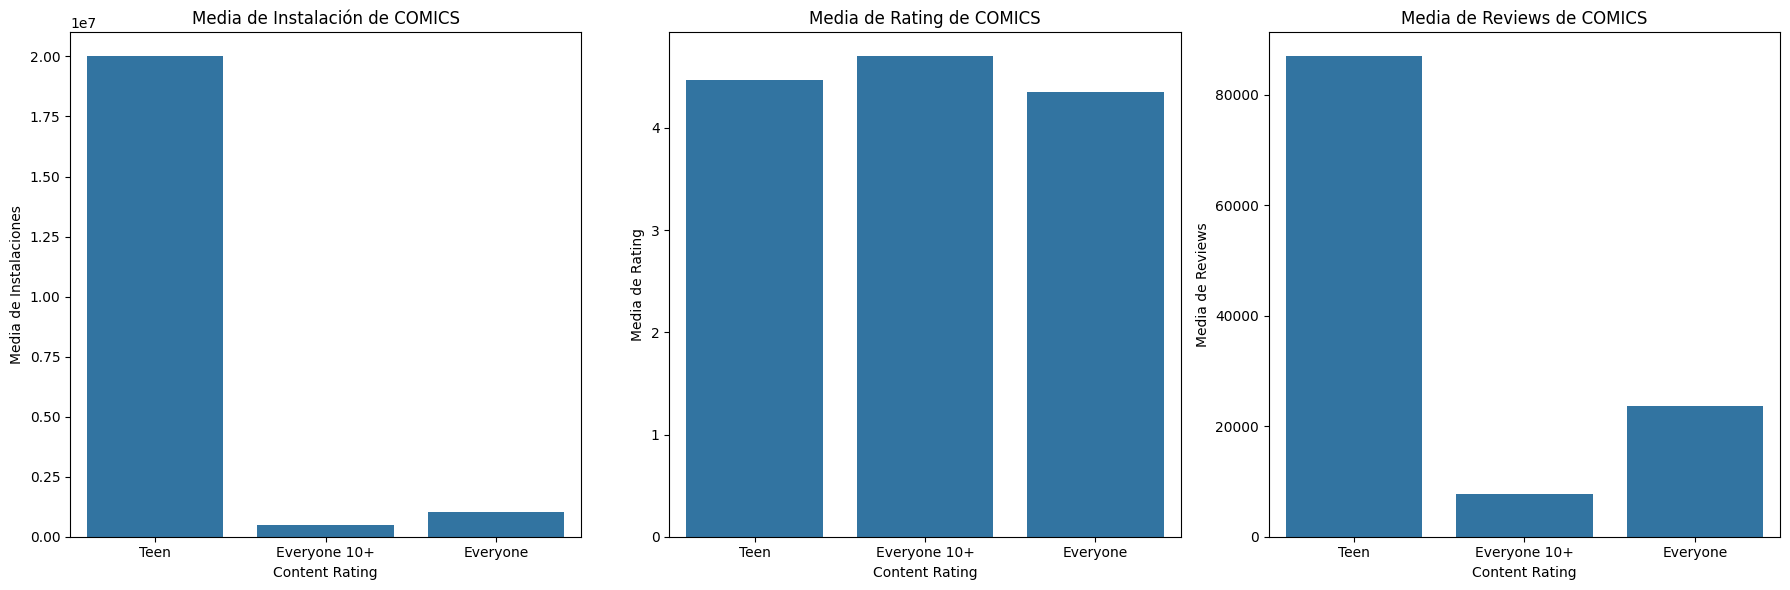

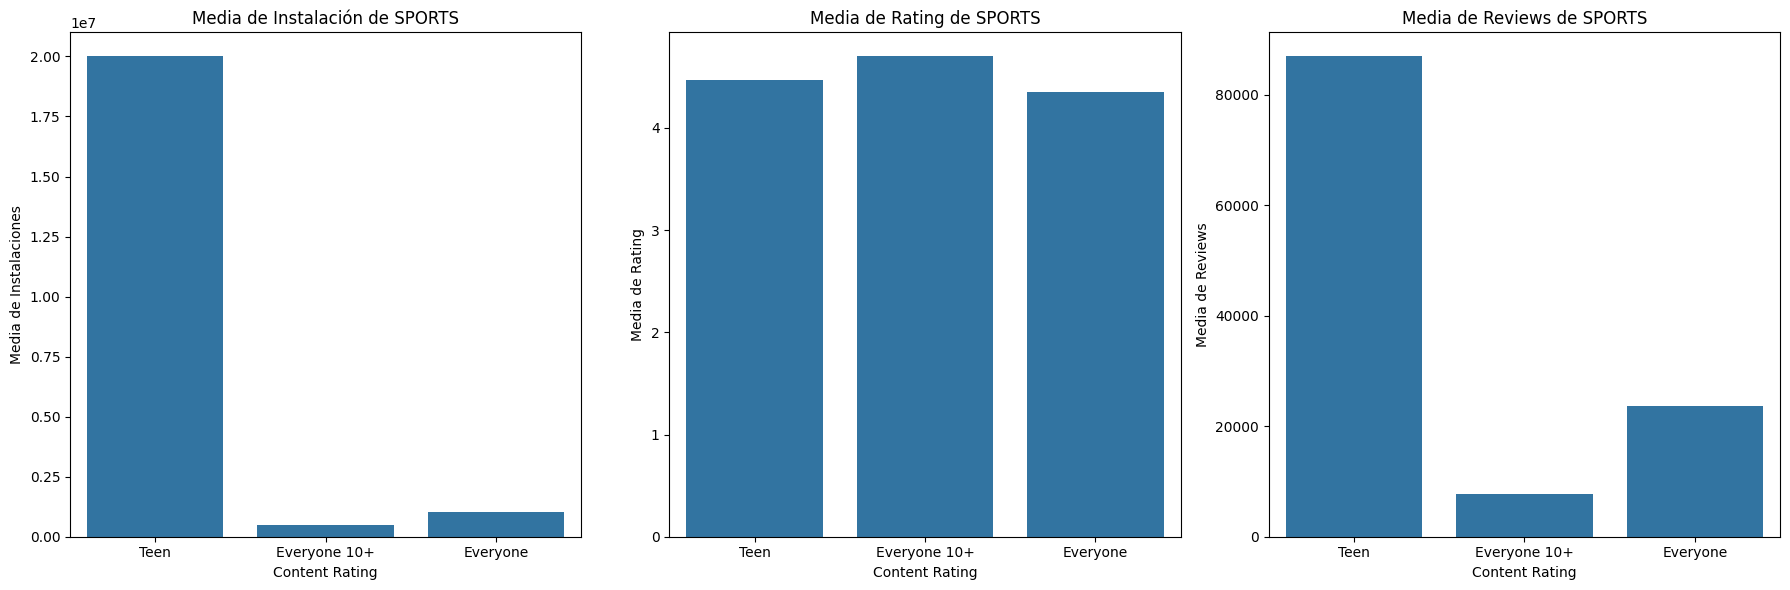

In [168]:
#Con nuestra lista de categorias, podemos ir a la ruta y cargar todos los csv
#NOTA: creo la variable contador para solo imprimir 3 y que se vea que funciona.
contador = 0

for i in lista:
    ruta = "../data/processed/datos_filtrados/"
    ruta = ruta + i + ".csv"
    df_temporal = spark.read.csv(ruta, header=True, inferSchema=True)
    df_temporal =df_temporal.toPandas()
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))


    sns.barplot(x="content rating", y="avg_installs", data=df_art, ax=axes[0])
    axes[0].set_title(f'Media de Instalación de {i}')
    axes[0].set_xlabel('Content Rating')
    axes[0].set_ylabel('Media de Instalaciones')


    sns.barplot(x="content rating", y="avg_rating", data=df_art, ax=axes[1])
    axes[1].set_title(f'Media de Rating de {i}')
    axes[1].set_xlabel('Content Rating')
    axes[1].set_ylabel('Media de Rating')


    sns.barplot(x="content rating", y="avg_reviews", data=df_art, ax=axes[2])
    axes[2].set_title(f'Media de Reviews de {i}')
    axes[2].set_xlabel('Content Rating')
    axes[2].set_ylabel('Media de Reviews')


    plt.tight_layout()

    plt.show() 

    if contador == 2:
        break
    else:
        contador = contador + 1

In [169]:
df_temporal

,Category,content rating,count,avg_installs,avg_rating,avg_reviews,version_mas_utilizada
0,SPORTS,Teen,16,8910100.000,4.140,278416.063,Varies with device
1,SPORTS,Mature 17+,7,3857142.857,4.286,205850.714,Varies with device
2,SPORTS,Everyone 10+,22,6843681.818,4.333,230376.273,Varies with device
3,SPORTS,Everyone,338,4230922.775,4.217,176971.189,Varies with device
4,SPORTS,Adults only 18+,1,1000000.000,4.500,50017.000,3.21.324


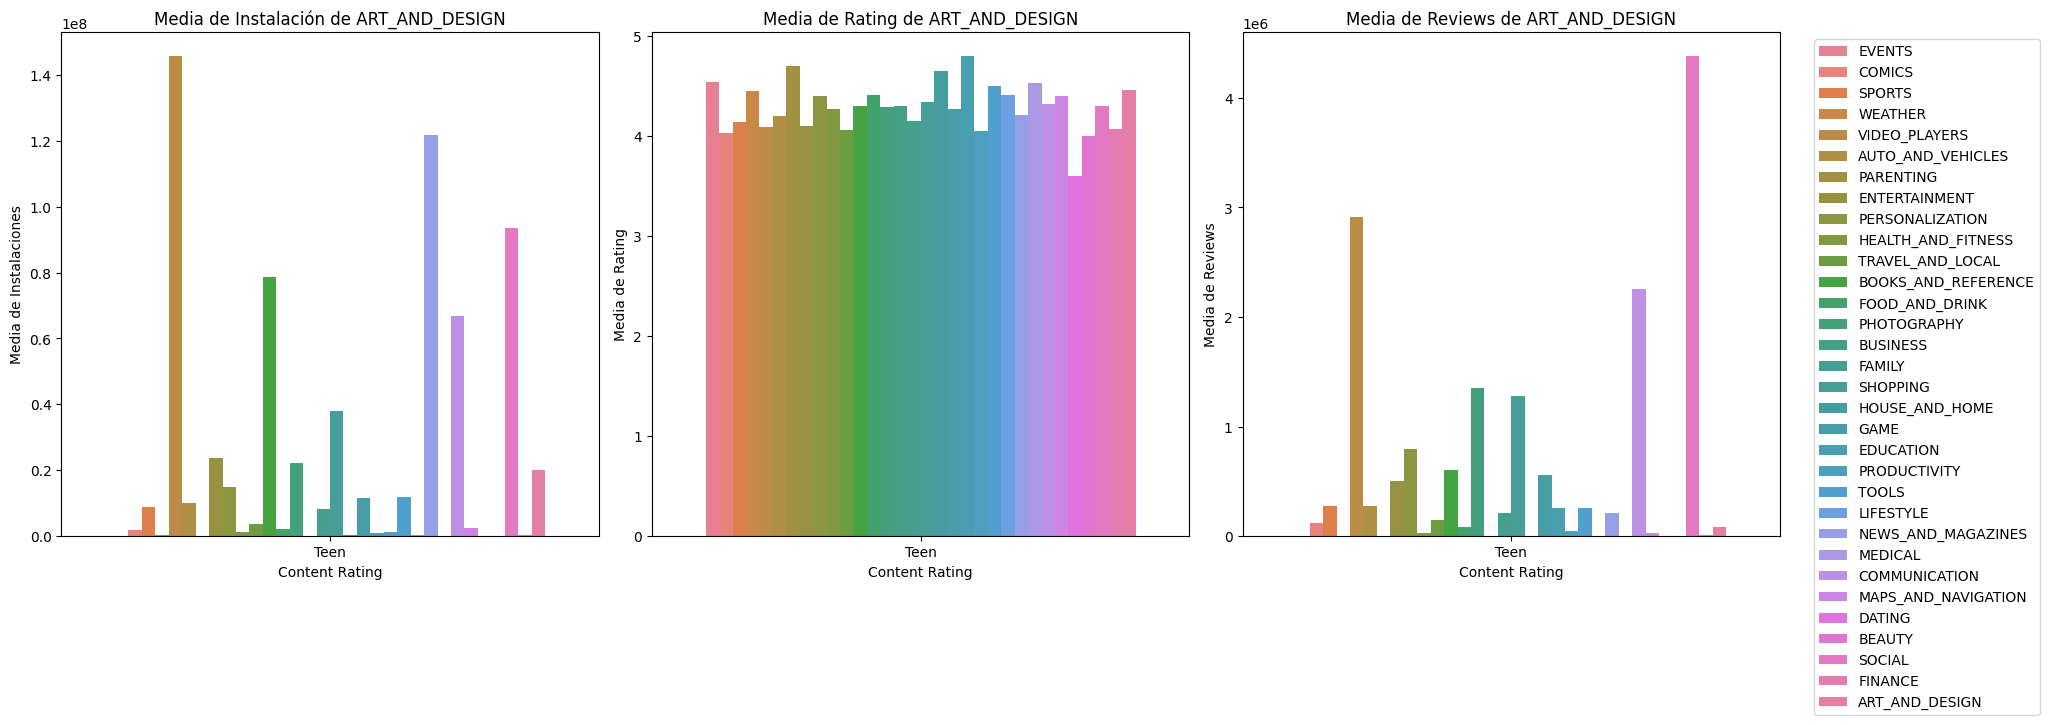

In [170]:
#Vamos a recorrer todas las Dataframes y guardar los valores de uno de los content rating.
#Despues, mostraremos en una grafica todos ellos.

df_teen = None

for i in lista:
    ruta = "../data/processed/datos_filtrados/"
    ruta = ruta + i + ".csv"
    df_temporal = spark.read.csv(ruta, header=True, inferSchema=True)

    if df_teen is None:
        df_teen = df_temporal.filter(col("content rating").contains("Teen"))
    else:
        df_teen = df_teen.unionByName(df_temporal.filter(col("content rating").contains("Teen")))

    

df_teen = df_teen.toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x="content rating", y="avg_installs", hue="Category",data=df_teen, errorbar=None, ax=axes[0])

axes[0].set_title(f'Media de Instalación de {i}')
axes[0].set_xlabel('Content Rating')
axes[0].set_ylabel('Media de Instalaciones')
axes[0].get_legend().remove()

sns.barplot(x="content rating", y="avg_rating", hue="Category", data=df_teen, errorbar=None, ax=axes[1])
axes[1].set_title(f'Media de Rating de {i}')
axes[1].set_xlabel('Content Rating')
axes[1].set_ylabel('Media de Rating')
axes[1].get_legend().remove()

sns.barplot(x="content rating", y="avg_reviews", hue="Category", data=df_teen, errorbar=None, ax=axes[2])
axes[2].set_title(f'Media de Reviews de {i}')
axes[2].set_xlabel('Content Rating')
axes[2].set_ylabel('Media de Reviews')
axes[2].get_legend().remove()

plt.tight_layout()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show() 

In [172]:
#No es del todo practico con tantas ya que es dificil segun los colores.
#Ultimo paso, hacer que salgan todas las content rating.

df_teen = None

for i in lista:
    ruta = "../data/processed/datos_filtrados/"
    ruta = ruta + i + ".csv"
    df_temporal = spark.read.csv(ruta, header=True, inferSchema=True)

    if df_teen is None:
        df_teen = df_temporal.filter(col("content rating").contains("Teen"))
    else:
        df_teen = df_teen.unionByName(df_temporal.filter(col("content rating").contains("Teen")))

    

df_teen = df_teen.toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x="content rating", y="avg_installs", hue="Category",data=df_teen, errorbar=None, ax=axes[0])

axes[0].set_title(f'Media de Instalación de {i}')
axes[0].set_xlabel('Content Rating')
axes[0].set_ylabel('Media de Instalaciones')
axes[0].get_legend().remove()

sns.barplot(x="content rating", y="avg_rating", hue="Category", data=df_teen, errorbar=None, ax=axes[1])
axes[1].set_title(f'Media de Rating de {i}')
axes[1].set_xlabel('Content Rating')
axes[1].set_ylabel('Media de Rating')
axes[1].get_legend().remove()

sns.barplot(x="content rating", y="avg_reviews", hue="Category", data=df_teen, errorbar=None, ax=axes[2])
axes[2].set_title(f'Media de Reviews de {i}')
axes[2].set_xlabel('Content Rating')
axes[2].set_ylabel('Media de Reviews')
axes[2].get_legend().remove()

plt.tight_layout()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show() 